# Random Forest Regressor

Single shot and predict one day ahead

The main idea to train and test the model is shown as follows:
1. Split the dataset into training set and test set (20% of the dataset is test set)
2. Use the training set to do cross validation to get the optimal combination of hyperparameters and get the mean squared error
3. Use the whole training set to train the model
4. Use the model to predict the mean_temp, min_temp, max_temp and precipitation

Import libraries

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

Load the data

In [22]:
df=pd.read_csv('../dataset_for_analysis/data_weather_new1.csv',parse_dates=['date'])

## Normalization and modelling

Define the feature and the targeted variables to be predicted

In [23]:
from sklearn.model_selection import train_test_split

X=df[['cloud_cover','sunshine','global_radiation','pressure']]
Y=df[['mean_temp','max_temp','min_temp','precipitation']]

xtrain,xtest,ytrain,ytest=train_test_split(X,Y,test_size=0.02385,shuffle=False)

Initiate the standard scaler

In [24]:
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
xtrain=scaler.fit_transform(xtrain)
xtest=scaler.fit_transform(xtest)

## Single output

### Optimal hyperparameters

In [25]:
# Initiate the model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit

# Initialize the Time Series Split
tscv = TimeSeriesSplit(n_splits=5)

# Define the SVR model
rfr = RandomForestRegressor()

Use grid search method to find the optimal combination of hyperparameters

mean_temp

In [30]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search over
param_grid = {
    'max_depth': [11,12,13],
    'min_samples_leaf': [35,36,37],
    'min_samples_split': [2,3,5]
}
# Create GridSearchCV instance with TimeSeriesSplit as cross-validation
grid_search = GridSearchCV(rfr, param_grid, scoring='neg_mean_squared_error', cv=tscv)

# Find the best values of hyperparameters for mean_temp prediction
grid_search.fit(xtrain, ytrain['mean_temp'])

# Print the results
best_params = grid_search.best_params_
best_score = -grid_search.best_score_
print("Best Parameters for mean_temp prediction: ", best_params)
print("Best Score (MSE) for mean_temp prediction: ", best_score)

Best Parameters for mean_temp prediction:  {'max_depth': 12, 'min_samples_leaf': 36, 'min_samples_split': 2}
Best Score (MSE) for mean_temp prediction:  15.639062482898813


Precipitation

In [36]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search over
param_grid = {
    'max_depth': [135,140,145],
    'min_samples_leaf': [85,90,95],
    'min_samples_split': [6]
}
# Create GridSearchCV instance with TimeSeriesSplit as cross-validation
grid_search = GridSearchCV(rfr, param_grid, scoring='neg_mean_squared_error', cv=tscv)

# Find the best values of hyperparameters for mean_temp prediction
grid_search.fit(xtrain, ytrain['precipitation'])

# Print the results
best_params = grid_search.best_params_
best_score = -grid_search.best_score_
print("Best Parameters for precipitation prediction: ", best_params)
print("Best Score (MSE) for precipitation  prediction: ", best_score)

Best Parameters for precipitation prediction:  {'max_depth': 135, 'min_samples_leaf': 95, 'min_samples_split': 6}
Best Score (MSE) for precipitation  prediction:  11.4159277623585


Use cross validation method to train and evaluate the model

In [37]:
models={
    'mean_temp': RandomForestRegressor(max_depth=12,min_samples_leaf=36,min_samples_split=2),
    'precipitation': RandomForestRegressor(max_depth=135,min_samples_leaf=95,min_samples_split=6),
    'min_temp': RandomForestRegressor(max_depth=12,min_samples_leaf=36,min_samples_split=2),
    'max_temp': RandomForestRegressor(max_depth=12,min_samples_leaf=36,min_samples_split=2),
}

In [38]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import numpy as np

# Initiate the Time Series Split
tscv=TimeSeriesSplit(n_splits=5)

# Train the models
for target_variable,model in models.items():

    # Store the mse value
    mse_scores=[]

    # Split the training set and test set
    for train_index,test_index in tscv.split(xtrain):
        X_train=X.iloc[train_index]
        y_train=Y[target_variable].iloc[train_index]

        X_test=X.iloc[test_index]
        y_test=Y[target_variable].iloc[test_index]

        # Normalize the data
        scaler=StandardScaler()
        X_train=scaler.fit_transform(X_train)
        X_test=scaler.fit_transform(X_test)

        # Train the model
        model.fit(X_train,y_train)

        # Make the predictions
        y_pred=model.predict(X_test)

        # Calculate the mean squared error
        mse=mean_squared_error(y_test,y_pred)
        mse_scores.append(mse)

    # Print the result
    print(f'MSE of {target_variable} prediction: {np.mean(mse_scores): .3f}')

MSE of mean_temp prediction:  15.412
MSE of precipitation prediction:  11.425
MSE of min_temp prediction:  16.193
MSE of max_temp prediction:  16.802


### Use the training set to train the model

In [39]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import numpy as np

for targeted_variable, model in models.items():
    model.fit(xtrain,ytrain[targeted_variable])

### Predict the data in 2020

In [40]:
predictions={}
for targeted_variable, model in models.items():
    prediction=model.predict(xtest)
    predictions[targeted_variable]=prediction
    print(f"MSE of {targeted_variable}: {mean_squared_error(predictions[targeted_variable],ytest[targeted_variable]): .3f}")

MSE of mean_temp:  16.644
MSE of precipitation:  11.019
MSE of min_temp:  17.853
MSE of max_temp:  15.980


In [42]:
# Predict the mean_temp in 2020
data_2020=df[df['date'].dt.year==2020]
X_2020=data_2020[['cloud_cover','sunshine','global_radiation','pressure']].values
scaled_X_2020=scaler.fit_transform(X_2020)
mean_temp_2020_pred=models['mean_temp'].predict(scaled_X_2020)
precipitation_2020_pred=models['precipitation'].predict(scaled_X_2020)
min_temp_2020_pred=models['min_temp'].predict(scaled_X_2020)
max_temp_2020_pred=models['max_temp'].predict(scaled_X_2020)

print(f"MSE of mean_temp: {mean_squared_error(data_2020['mean_temp'],mean_temp_2020_pred): .3f}")
print(f"MSE of precipitation: {mean_squared_error(data_2020['precipitation'],precipitation_2020_pred): .3f}")
print(f"MSE of min_temp: {mean_squared_error(data_2020['min_temp'],min_temp_2020_pred): .3f}")
print(f"MSE of max_temp: {mean_squared_error(data_2020['max_temp'],max_temp_2020_pred): .3f}")


MSE of mean_temp:  16.644
MSE of precipitation:  11.019
MSE of min_temp:  17.853
MSE of max_temp:  15.980


Visualize the result

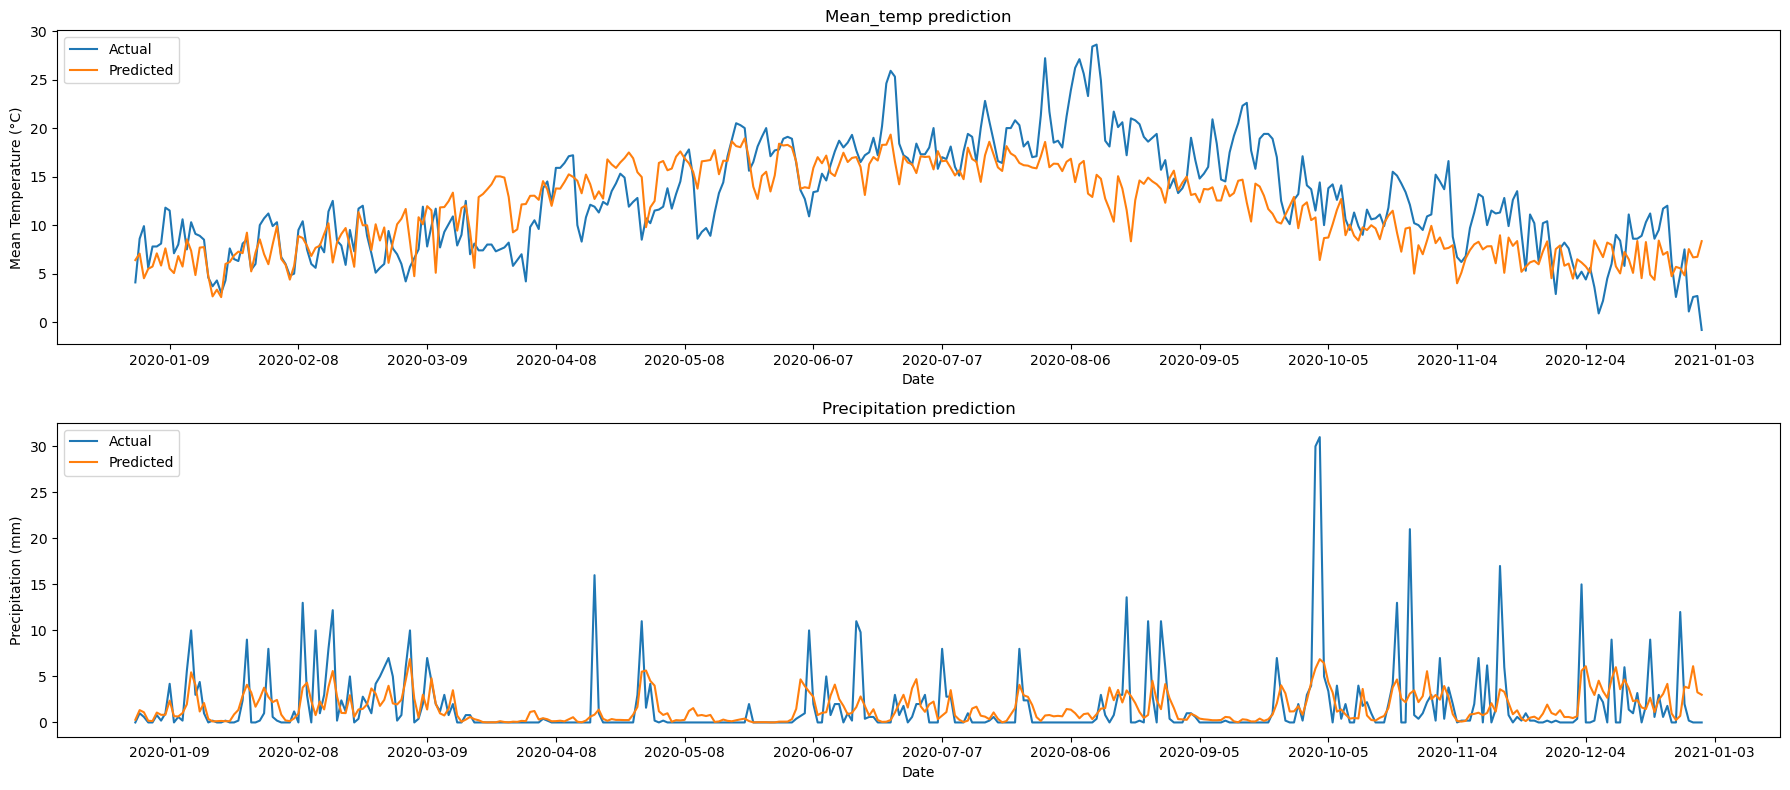

In [43]:

# Create the figure containing two subplots
fig,(ax1,ax2)=plt.subplots(2,1,figsize=(18,8))

# The plot for mean_temp
ax1.plot(data_2020['date'],data_2020['mean_temp'],label='Actual')
ax1.plot(data_2020['date'],mean_temp_2020_pred, label='Predicted')
ax1.set_xlabel('Date')
ax1.set_ylabel('Mean Temperature (°C)')
ax1.set_title('Mean_temp prediction')
ax1.legend(loc='upper left')

# The plot for precipitation
ax2.plot(data_2020['date'], data_2020['precipitation'],label='Actual')
ax2.plot(data_2020['date'], precipitation_2020_pred,label='Predicted')
ax2.set_xlabel('Date')
ax2.set_ylabel('Precipitation (mm)')
ax2.set_title('Precipitation prediction')
ax2.legend(loc='upper left')

ax1.xaxis.set_major_locator(plt.MaxNLocator(14))
ax2.xaxis.set_major_locator(plt.MaxNLocator(14))

# Adjust the layout of the subplots
plt.tight_layout()
plt.show()

## Multiple output

Train and test the model

In [45]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV

# Define the SVR model
rfr=RandomForestRegressor()
model = MultiOutputRegressor(rfr)

# Define the parameter grid to search over
param_grid = {
    'estimator__max_depth': [5,10,20],
    'estimator__min_samples_leaf': [40,50,60]  # Add gamma values here
}

# Create GridSearchCV instance
grid_search = GridSearchCV(model, param_grid, cv=tscv, scoring='neg_mean_squared_error')

mse_scores = []

for train_index, test_index in tscv.split(df):
    X_train = X.iloc[train_index]
    y_train = Y.iloc[train_index]

    X_test = X.iloc[test_index]
    y_test = Y.iloc[test_index]

    # Normalize the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Fit the grid search to the data
    grid_search.fit(X_train_scaled, y_train)

    # Get the best model from grid search
    best_model = grid_search.best_estimator_

    # Make the predictions
    y_pred = best_model.predict(X_test_scaled)

    # Calculate the mean squared error
    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)

# Print the result
print(f'Best hyperparameters: {grid_search.best_params_}')
print(f'MSE of prediction: {np.mean(mse_scores):.2f}')


Best hyperparameters: {'estimator__max_depth': 10, 'estimator__min_samples_leaf': 40}
MSE of prediction: 15.04


Evaluate the model

In [49]:
from sklearn.multioutput import MultiOutputRegressor

rfr=RandomForestRegressor(max_depth=10,min_samples_leaf=40)
model=MultiOutputRegressor(rfr)

mse_scores1=[]

for train_index,test_index in tscv.split(df):
    X_train=X.iloc[train_index]
    y_train=Y.iloc[train_index]

    X_test=X.iloc[test_index]
    y_test=Y.iloc[test_index]

    # Normalize the data
    X_train=scaler.fit_transform(X_train)
    X_test=scaler.fit_transform(X_test)

    # Train the model
    model.fit(X_train,y_train)

    # Make the predictions
    y_pred=model.predict(X_test)

    # Calculate the mean squared error
    mse=mean_squared_error(y_test,y_pred)
    mse_scores1.append(mse)

# Print the result
print(f'MSE of prediction: {np.mean(mse_scores1): .2f}')

MSE of prediction:  15.04


Predict the data in 2020

In [51]:
y_pred_2020_multi=model.predict(scaled_X_2020)
print(f"MSE for multiple output of 2020 data: {mean_squared_error(data_2020[['mean_temp','max_temp','min_temp','precipitation']].values,y_pred_2020_multi): .3f}")

MSE for multiple output of 2020 data:  15.690
